# ADNI ConvNet

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import numpy as np
import nibabel as nib
import datetime as dt

import os
import os.path as osp
import glob

import captum
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from matplotlib.widgets import Slider

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms

from captum.attr import IntegratedGradients, LRP, LayerGradCam, LayerAttribution, Occlusion, DeepLiftShap, GuidedBackprop, InputXGradient

from tqdm.notebook import tqdm, trange
from sklearn.model_selection import StratifiedKFold, train_test_split

from model import *
from data import *

In [2]:
torch.manual_seed(19)

In [3]:
import seaborn as sns

# use seaborne theme for nice looking plots
sns.set_theme(style="darkgrid")

In [4]:
WEIGHT_DECAY = 1e-3
LR = 0.001

EPOCHS = 30
BATCH_SIZE = 16

KFOLD_EPOCHS = 30
KFOLD_SPLITS = 5

## Load Preprocessed ADNI Dataset

In [5]:
cn_files = glob.glob(osp.join(DATA_PATH, "CN", "*.nii.gz"))
print("Found {} CN files.".format(len(cn_files)))

ad_files = glob.glob(osp.join(DATA_PATH, "AD", "*.nii.gz"))
print("Found {} AD files.".format(len(ad_files)))

f_ds = np.array(cn_files + ad_files)

Found 254 CN files.
Found 189 AD files.


In [6]:
X = load_nifti(f_ds, transform=crop)
y = torch.tensor([0] * len(cn_files) + [1] * len(ad_files))

## Create a 3D ConvNet for ADNI

In [13]:
adni_net.to("cuda")

AdniNet(
  (cb1): ConvBlock(
    (conv3d): Conv3d(1, 5, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (batchnorm): BatchNorm3d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool3d): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (cb2): ConvBlock(
    (conv3d): Conv3d(5, 5, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (batchnorm): BatchNorm3d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool3d): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (cb3): ConvBlock(
    (conv3d): Conv3d(5, 5, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (batchnorm): BatchNorm3d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool3d): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (linear1): Linear(in_features=10800, out_featur

In [14]:
adni_net = AdniNet()
# don't provide batch dimension for torch summary!
summary(adni_net, input_size=(1,100,120,100))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

Parameters of the Network in InteractiveViz Demo Notebook 2:

```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv3d_1 (Conv3D)            (None, 100, 100, 120, 5)  140       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 50, 50, 60, 5)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 60, 5)     20        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 50, 50, 60, 5)     680       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 25, 25, 30, 5)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 25, 25, 30, 5)     20        
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 25, 25, 30, 5)     680       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 12, 12, 15, 5)     0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 15, 5)     20        
_________________________________________________________________
flatten_1 (Flatten)          (None, 10800)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                691264    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
=================================================================
Total params: 694,970
Trainable params: 694,940
Non-trainable params: 30
```

## Stratified k-Fold

In [15]:
def train(model, optim, loader, loss_fn, pbar=None):
    ls = []
    model.train()
    for batch_id, (X, y_target) in enumerate(loader):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y_target)
        ls.append(loss.item())
        loss.backward()
        optimizer.step()
        if pbar is not None:
            pbar.update()
    return ls


def validate(model, loader, loss_fn):
    model.eval()
    correct = 0
    total = 0
    loss = 0

    for batch_id, (X, y_target) in enumerate(loader):
        with torch.no_grad():
            y_pred = model(X)
            # normalize logits with log softmax for NLL-Loss
            # y_pred = F.log_softmax(y_pred, dim=1)
            loss += loss_fn(y_pred, y_target).item()
            vals, idxs = y_pred.max(dim=1)
            correct += (idxs == y_target).sum()
            total += len(y_target)

    acc = correct / total
    return acc, loss / total

In [16]:
def save_model(model, model_name=""):
    if not osp.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    if not model_name:
        timestamp = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
        model_name = osp.join(MODEL_ROOT, "model-{}.pt".format(timestamp))
    torch.save(model.state_dict(), model_name)
    return path

In [ ]:
torch.manual_seed(19)
skf = StratifiedKFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=np.random.RandomState(19))

histories = []
loss = []

for i, (train_idxs, test_idxs) in enumerate(skf.split(X, y)):
    h = []
    l = []
    torch.save((train_idxs, test_idxs), osp.join(MODEL_PATH, "idxs-{}.pt".format(i)))
    kmu = X[train_idxs].mean()
    ksigma = X[train_idxs].std()
    tf_ktrain = Compose([Normalize(kmu, ksigma), augment])
    tf_ktest = Compose([Normalize(kmu, ksigma)])
    
    train_ds = TransformTensorDataset(X[train_idxs], y[train_idxs], transform=tf_ktrain)
    test_ds = TransformTensorDataset(X[test_idxs], y[test_idxs], transform=tf_ktest)
    train_loader = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_ds, shuffle=True, batch_size=BATCH_SIZE)
    
    model = AdniNet()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
       
    pbar = tqdm(total=KFOLD_EPOCHS)
    for epoch in range(KFOLD_EPOCHS + 1):
        ta, tl = validate(model, train_loader, nn.CrossEntropyLoss())
        va, vl = validate(model, test_loader, nn.CrossEntropyLoss())
        pbar.set_description("Loss: {:.3f} | Train: {:.3f} | Val: {:.3f}".format(tl, ta, va))
        h.append({"train_loss": tl, "train_acc": ta, "val_loss": vl, "val_acc": va})
        if epoch > 0:
            pbar.update()
        if epoch < KFOLD_EPOCHS:
            l += train(model, optimizer, train_loader, nn.CrossEntropyLoss())
    pbar.close()
    loss.append(l)
    histories.append(h)
    path = osp.join(MODEL_PATH, "kfold-{}.pt".format(i))
    save_model(model, path)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [3]:
vas = np.array([[x["val_acc"] for x in h] for h in histories]) * 100
mu_va = vas.mean(axis=0)
sigma_va = vas.std(axis=0)

plt.fill_between(np.arange(len(mu_va)), mu_va - sigma_va, mu_va + sigma_va, color="grey", alpha=0.2)
for va in vas:
    plt.plot(np.array(va), alpha=0.5)
plt.plot(mu_va, label="mean", marker="o", color="black")

#plt.legend()
#plt.set_title("{}-Fold Validation Accuracy".format(KFOLD_SPLITS))
plt.ylim(0, 100)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.show()

NameError: name 'histories' is not defined

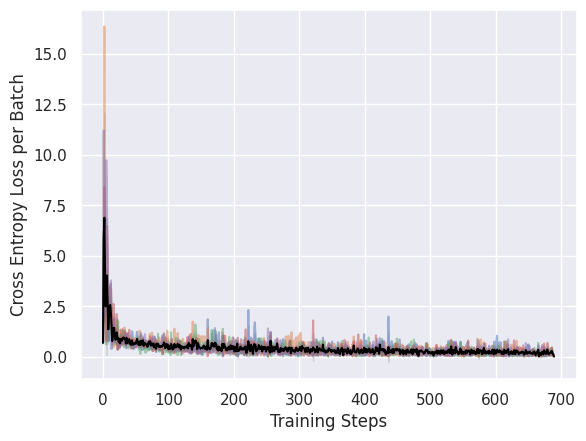

In [ ]:
l = np.array(loss)
mu_loss = l.mean(axis=0)
sigma_loss = l.std(axis=0)

plt.fill_between(np.arange(len(mu_loss)), mu_loss - sigma_loss, mu_loss + sigma_loss, color="grey", alpha=0.2)
for i in range(KFOLD_SPLITS):
    plt.plot(l[i], alpha=0.5)
plt.plot(mu_loss, label="mean", color="black")

#plt.legend()
#plt.set_title("{}-Fold Validation Accuracy".format(KFOLD_SPLITS))
plt.xlabel("Training Steps")
plt.ylabel("Cross Entropy Loss per Batch")
plt.show()

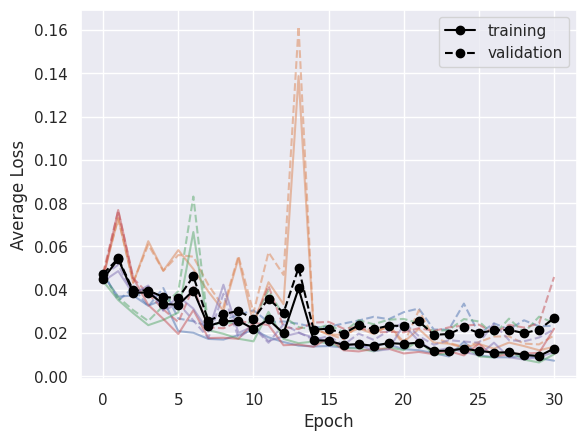

In [ ]:
tls = [np.array([x["train_loss"] for x in h]) for h in histories]
vls = [np.array([x["val_loss"] for x in h]) for h in histories]

mu_tls = np.array(tls).mean(axis=0)
mu_vls = np.array(vls).mean(axis=0)

for tl, vl in zip(tls, vls):
    lines = plt.plot(tl, alpha=0.5)
    c = lines[0].get_color()
    plt.plot(vl, alpha=0.5, color=c, linestyle="--")

plt.plot(mu_tls, label="training", marker="o", color="black")
plt.plot(mu_vls, label="validation", marker="o", color="black", linestyle="--")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()

In [ ]:
torch.manual_seed(19)
skf = StratifiedKFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=np.random.RandomState(19))

y_preds = []
y_true = []

for i, (train_idxs, test_idxs) in enumerate(skf.split(X, y)):
    kmu = X[train_idxs].mean()
    ksigma = X[train_idxs].std()
    tf_ktest = Compose([Normalize(kmu, ksigma)])
    
    test_ds = TransformTensorDataset(X[test_idxs], y[test_idxs], transform=tf_ktest)
    test_loader = DataLoader(test_ds, shuffle=True, batch_size=BATCH_SIZE)
    
    model = AdniNet()
    path = osp.join(MODEL_PATH, "kfold-{}.pt".format(i))
    model.load_state_dict(torch.load(path))
    model.eval()
    
    y_pred = []
    labels = []
    for (x, label) in test_loader:
        y_pred.append(F.softmax(model(x), 1))
        labels.append(label)
    y_pred = torch.cat(y_pred, 0)
    labels = torch.cat(labels, 0)
    y_preds.append(y_pred)
    y_true.append(labels)
    acc = (y_pred.argmax(1) == labels).sum().item() / len(labels)
    print("Fold {} Test Accuracy: {:.2f} %".format(i, acc * 100))

Fold 0 Test Accuracy: 88.76 %
Fold 1 Test Accuracy: 87.64 %
Fold 2 Test Accuracy: 87.64 %
Fold 3 Test Accuracy: 85.23 %
Fold 4 Test Accuracy: 87.50 %


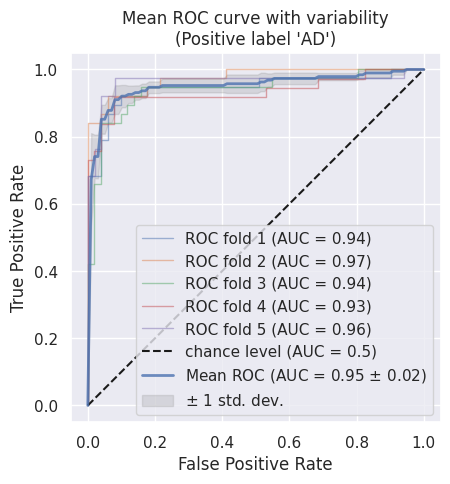

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

# adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

fig, ax = plt.subplots()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i in range(KFOLD_SPLITS):
    
    viz = RocCurveDisplay.from_predictions(
        y_true[i].detach().numpy(),
        y_preds[i][:,1].detach().numpy(),
        name=f"ROC fold {i+1}",
        alpha=0.5,
        lw=1,
        ax=ax,
    )
    
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label 'AD')",
)
ax.axis("square")
# ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
ax.legend(loc="lower right")
plt.savefig("figures/kfold_roc.png", bbox_inches="tight")
plt.show()

In [ ]:
model = AdniNet()
path = osp.join(MODEL_PATH, "kfold-1.pt")
model.load_state_dict(torch.load(path))
model.eval()

path = osp.join(MODEL_PATH, "adni_net.pt")
save_model(model, path)

'models/adni_net.pt'

## Full Dataset Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,
                                                    shuffle=True, stratify=y, random_state=19)

In [ ]:
print(X_train.mean(), X_train.std())

tensor(0.1291) tensor(0.2361)


In [ ]:
train_ds = TransformTensorDataset(X_train, y_train, transform=tf_train)
test_ds = TransformTensorDataset(X_test, y_test, transform=tf_test)
train_loader = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
torch.manual_seed(19)
adni_net = AdniNet()
optimizer = optim.Adam(adni_net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

hist = []

pbar = tqdm(total=EPOCHS)
for epoch in range(EPOCHS + 1):
    ta, tl = validate(adni_net, train_loader, nn.CrossEntropyLoss())
    va, vl = validate(adni_net, test_loader, nn.CrossEntropyLoss())
    pbar.set_description("Loss: {:.3f} | Train: {:.3f} | Val: {:.3f}".format(tl, ta, va))
    hist.append({"train_loss": tl, "train_acc": ta, "val_loss": vl, "val_acc": va})
    if epoch > 0:
        pbar.update()
    if epoch < EPOCHS:
        train(adni_net, optimizer, train_loader, nn.CrossEntropyLoss())
pbar.close()

path = osp.join(MODEL_PATH, "adni_net.pt")
save_model(adni_net, path)

  0%|          | 0/30 [00:00<?, ?it/s]

'models/adni_net.pt'

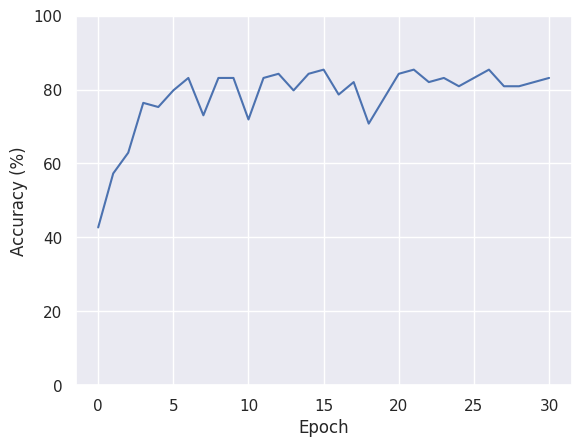

In [ ]:
plt.plot(np.array([h["val_acc"] for h in hist]) * 100)
plt.ylim(0,100)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.show()

In [ ]:
test_acc, test_loss = validate(adni_net, test_loader, nn.CrossEntropyLoss())
print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {:.2f} %".format(test_acc.item() * 100))

Test Loss: 0.02892088789618417
Test Accuracy: 83.15 %


In [ ]:
from sklearn.metrics import RocCurveDisplay

adni_net.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for x,y in tqdm(test_loader):
        y_true.append(y)
        y_pred.append(adni_net(x))
y_true = torch.cat(y_true, 0)
y_pred = F.softmax(torch.cat(y_pred,0), 1)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
y_true

tensor([1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0])

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred[:,1])

0.9153766769865841

In [ ]:
y_gt

tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1])

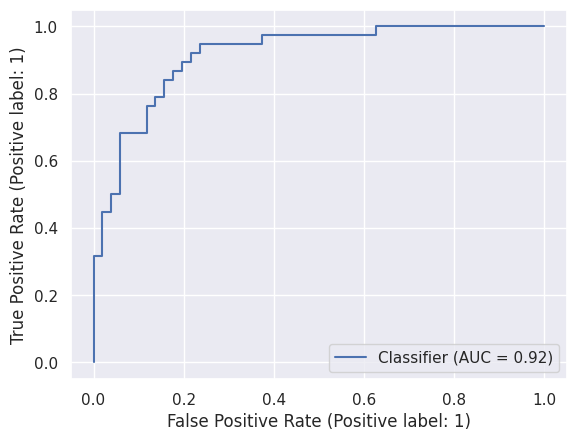

In [ ]:
RocCurveDisplay.from_predictions(y_true, y_pred[:,1])

In [ ]:
def view_brain(data, attr=None, threshold=-1):
    """View MRI data with optional attribution overlay.
    Use cmap RdBu and attr_norm "centered" to include negative attributions.
    mix: blend (with transparency) or threshold"""
    AXES = ["sagital", "coronal", "axial"]
    ims = [0,1,2]
    attr_ims = [0,1,2]
    sliders = []
    init_data = [data[0,:,:].T, data[:,0,:].T, data[:,:,0].T]
    init_attr = None
    init_alphas = None
    data = np.array(data)
    alphas = np.zeros_like(data)
    
    if attr is not None:
        attr = np.array(attr)
        alphas = abs(attr)
        if alphas.max() > 0:
            alphas /= alphas.max()
        if threshold >= 0:
            alphas = (alphas > threshold) * np.ones_like(alphas)
        init_attr = [attr[0,:,:].T, attr[:,0,:].T, attr[:,:,0].T]
        init_alphas = [alphas[0,:,:].T, alphas[:,0,:].T, alphas[:,:,0].T]
    
    fig, axs = plt.subplots(1, 3, figsize=(8,5))
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.8)

    for i in range(3):
        ims[i] = axs[i].imshow(init_data[i], cmap="gray", origin="lower", vmin=data.min(), vmax=data.max())
        if attr is not None:
            hr = abs(attr).max()
            norm = colors.CenteredNorm(halfrange=hr)
            attr_ims[i] = axs[i].imshow(init_attr[i], cmap="coolwarm", origin="lower", norm=norm, alpha=init_alphas[i])
        # axs[i].axis('off')
        axs[i].grid(False)
        axs[i].set_title(AXES[i])
        
        ax_slider = fig.add_axes([0.08 + i*0.3, 0.15, 0.24, 0.02])
        slider = Slider(
            label="",
            ax=ax_slider,
            valmin=0,
            valmax=data.shape[i]-1,
            valstep=1,
            valinit=0,
            orientation="horizontal",
            valfmt="%s"
        )
        #slider.valtext.set_visible(False)
        slider.label.set_visible(False)
        sliders.append(slider)
    
    def draw_lines():
        for i in range(3):
            axs[i].lines.clear()
        axs[0].axline((0, sliders[2].val), (1, sliders[2].val))
        axs[0].axline((sliders[1].val, 0), (sliders[1].val, 1))
        axs[1].axline((sliders[0].val, 0), (sliders[0].val, 1))
        axs[1].axline((0, sliders[2].val), (1, sliders[2].val))
        axs[2].axline((sliders[0].val, 0), (sliders[0].val, 1))
        axs[2].axline((0, sliders[1].val), (1, sliders[1].val))

    def update(im_idx, val):
        draw_lines()
        d = np.rollaxis(data, im_idx, 0)[int(val),:,:].T
        ims[im_idx].set_data(d)
        #ims[im_idx].autoscale()
        
        if not attr is None:
            a = np.rollaxis(attr, im_idx, 0)[int(val),:,:].T
            #alpha = np.rollaxis(alphas, im_idx, 0)[int(val),:,:].T
            alpha = np.rollaxis(alphas, im_idx, 0)[int(val),:,:].T
            attr_ims[im_idx].set_data(a)
            attr_ims[im_idx].set_alpha(alpha)
            #attr_ims[im_idx].autoscale()
    
    sliders[0].on_changed(lambda val: update(0, val))
    sliders[1].on_changed(lambda val: update(1, val))
    sliders[2].on_changed(lambda val: update(2, val))
    
    return fig, axs, sliders

In [ ]:
def view_slice(data, axis, slice_idx, attr=None, ax=None, threshold=-1):
    fig = None
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.grid(False)
    
    d = np.rollaxis(np.array(data), axis, 0)[slice_idx, :, :].T
    ax.imshow(d, cmap="gray", origin="lower", vmin=data.min(), vmax=data.max())
    
    if attr is not None:
        attr = np.array(attr)
        alphas = abs(attr)
        if alphas.max() > 0:
            alphas /= alphas.max()
        if threshold >= 0:
            alphas = (alphas > threshold) * np.ones_like(alphas)
        a = np.rollaxis(attr, axis, 0)[slice_idx, :, :].T
        alpha = np.rollaxis(alphas, axis, 0)[slice_idx, :, :].T
        ax.imshow(a, origin="lower", cmap="coolwarm", norm=colors.CenteredNorm(), alpha=alpha)
    
    return fig, ax